In [79]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 03
## FIFA dataset 

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [80]:
###-----------------
### Import Libraries
###-----------------

import os
# import numpy as np # type: ignore #Commented out Numpy to demonstrate tensor is as versatile as numpy. Tensors are meant for GPU.
import pandas as pd # type: ignore

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
import matplotlib.pyplot as plt # type: ignore

import torch
import torch.nn as nn


# os.chdir("/home/pgdai/Desktop/DNN-May24/study material-20240518T025337Z-001/study material/utils")
# from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [81]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [82]:

###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


In [83]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


In [84]:
print (fn_plot_torch_hist.__doc__)

None


In [85]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [86]:
###----------------------
### Some basic parameters
###----------------------

#Directories so that we can save the trained model, the outputs and the inputs
inpDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureThings/Day5/input'
outDir = '../../../output'
modelDir = '../../../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

torch.manual_seed(RANDOM_STATE)

EPOCHS = 2001 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
ALPHA = 0.001 # learning rate

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [87]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [88]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [89]:
for col in data_df.columns:
    print(f"{col}: {data_df[col].unique}")

Unnamed: 0: <bound method Series.unique of 0            0
1            1
2            2
3            3
4            4
         ...  
18202    18202
18203    18203
18204    18204
18205    18205
18206    18206
Name: Unnamed: 0, Length: 18207, dtype: int64>
ID: <bound method Series.unique of 0        158023
1         20801
2        190871
3        193080
4        192985
          ...  
18202    238813
18203    243165
18204    241638
18205    246268
18206    246269
Name: ID, Length: 18207, dtype: int64>
Name: <bound method Series.unique of 0                  L. Messi
1         Cristiano Ronaldo
2                 Neymar Jr
3                    De Gea
4              K. De Bruyne
                ...        
18202          J. Lundstram
18203    N. Christoffersson
18204             B. Worman
18205        D. Walker-Rice
18206             G. Nugent
Name: Name, Length: 18207, dtype: object>
Age: <bound method Series.unique of 0        31
1        33
2        26
3        27
4        27
         ..


In [90]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [91]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18147.0,9089.239599,5257.923360,0.0,4536.5,9076.0,13662.5,18206.0
ID,18147.0,214279.818868,29970.319078,16.0,200305.5,221740.0,236512.5,246620.0
Age,18147.0,25.121122,4.669796,16.0,21.0,25.0,28.0,45.0
Overall,18147.0,66.253926,6.913320,46.0,62.0,66.0,71.0,94.0
Potential,18147.0,71.324076,6.132286,48.0,67.0,71.0,75.0,95.0
Special,18147.0,1598.002645,272.882706,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18147.0,1.113297,0.394150,1.0,1.0,1.0,1.0,5.0
Weak Foot,18147.0,2.947154,0.660498,1.0,3.0,3.0,3.0,5.0
Skill Moves,18147.0,2.361492,0.756274,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [92]:
data_df['Position'].isnull().sum()

0

In [93]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [94]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [95]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [96]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [97]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [98]:
y = data_df['Position'].to_numpy()

X = data_df.drop('Position', axis=1)

X.shape, y.shape

((18147, 33), (18147,))

In [99]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [100]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     stratify=y,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [101]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [102]:
list(labels.keys())

[0, 1, 2, 3]

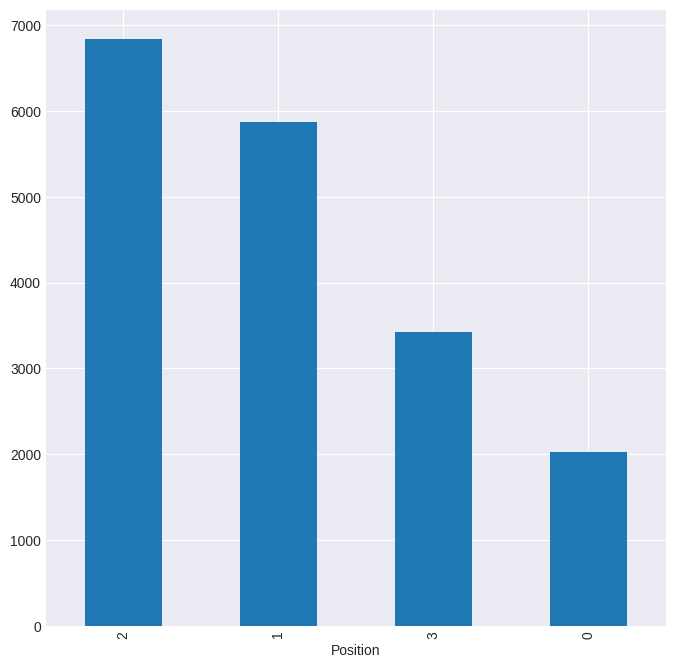

In [103]:
fig = plt.figure(figsize=(8,8))
data_df['Position'].value_counts().plot(kind = "bar");


In [104]:
X_train.shape

(14517, 33)

In [105]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [114]:
# in torch we have to give incoming as well as Outgoing dimension.

input_dim = X_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_dim, 18),
    nn.Tanh(),
    nn.Linear( 18, 4),).to(device=device)

In [115]:
print(model)

Sequential(
  (0): Linear(in_features=33, out_features=18, bias=True)
  (1): Tanh()
  (2): Linear(in_features=18, out_features=4, bias=True)
)


In [116]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0958, -0.1400, -0.0629,  0.0550,  0.0568,  0.0937,  0.0253, -0.0004,
          -0.0007,  0.0398, -0.0754, -0.0321, -0.0472,  0.1082, -0.0941, -0.1445,
          -0.1360, -0.0008, -0.0770, -0.0080,  0.1414,  0.0576, -0.0078,  0.1121,
          -0.0815, -0.0883, -0.0315, -0.1452,  0.1669,  0.0443,  0.0160, -0.1511,
          -0.1213],
         [-0.1372, -0.1709, -0.1022, -0.1531, -0.1206,  0.0041, -0.1138, -0.0545,
           0.1615, -0.0434,  0.0769,  0.1601, -0.0250,  0.0948,  0.1380, -0.0562,
          -0.0603, -0.1606, -0.1158, -0.1532, -0.0618, -0.0960, -0.1465,  0.0618,
           0.0396, -0.0662, -0.0474,  0.0236,  0.1345,  0.0984,  0.0296, -0.0097,
           0.0357],
         [ 0.0163,  0.0440, -0.0385, -0.0275, -0.0518,  0.1166, -0.0710, -0.1461,
          -0.0036, -0.0658, -0.0835,  0.1259, -0.1451, -0.1050,  0.1351,  0.1510,
          -0.1210,  0.1237, -0.1600,  0.0424,  0.0084,  0.1067,  0.1480, -0.0099,
          -0.0731, -0.1433,  0.0266

In [117]:
print (f'Num Parameters: {len(list(model.parameters()))}')  
print (f'Layer 1: Weights : {list(model.parameters())[0].shape}')
print (f'Layer 1: Bias    : {list(model.parameters())[1].shape}')
print (f'Layer 2: Weights : {list(model.parameters())[2].shape}')
print (f'Layer 2: Bias    : {list(model.parameters())[3].shape}')

Num Parameters: 4
Layer 1: Weights : torch.Size([18, 33])
Layer 1: Bias    : torch.Size([18])
Layer 2: Weights : torch.Size([4, 18])
Layer 2: Bias    : torch.Size([4])


In [118]:
train_X = torch.tensor(X_train, dtype=torch.float32, device=device)
train_y = torch.tensor(y_train, dtype=torch.int64, device=device)

test_X = torch.tensor(X_test, dtype=torch.float32, device=device)
test_y = torch.tensor(y_test, dtype=torch.int64, device=device)

In [119]:
train_X[:1].shape, train_X[0].shape

(torch.Size([1, 33]), torch.Size([33]))

In [124]:
predict_prob = model(train_X[:1]) # make predictions 
# predict_prob.detach().cpu().numpy()  # this line of code is for Colab where we need to ensure it is run by CPU
predict_prob.detach().numpy() #this is for ones running on local machine whose it is already running on cpu not gpu

array([[-2.0043283, -3.2243388,  1.4812123,  5.016395 ]], dtype=float32)

In [125]:
y_train[0]

3

In [126]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Iterations
for epoch in range (EPOCHS):
    
    model.train() # Set the model in training mode
    
    predict_prob = model(train_X) # make predictions
    
    curr_loss = loss_fn(predict_prob, train_y) # calculate loss

    ###---------------
    ### Back prop step (Must to write lines on this version ;)
    ###---------------
    optimizer.zero_grad()
    curr_loss.backward() #the weights and biases are appropriately adjusted
    optimizer.step() # It tells in which direction to take the one step in the most optimised way 

In [ ]:

del model #deletes the old model

model = nn.Sequential(
    nn.Linear( input_dim, 18),
    nn.Tanh(),
    nn.Linear( 18, 4)
).to(device=device)

In [129]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Some lists to collect data (added new)
loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

# Iterations
for epoch in range (EPOCHS):
    
    model.train() # Set the model in training mode
    
    predict_prob = model(train_X) # make predictions
    
    curr_loss = loss_fn(predict_prob, train_y) # calculate loss

    ###---------------
    ### Back prop step
    ###---------------
    optimizer.zero_grad() 
    curr_loss.backward()
    optimizer.step()

    loss.append ( curr_loss.data.item() ) # append to loss list
    
    _, y_pred = torch.max(predict_prob, 1) # get predicted class from the probabilities
        
    curr_acc = accuracy_score( y_train, y_pred.data.cpu()) # move to CPU -  also works without .cpu()
    
    acc.append(curr_acc) # append to accuracy list
    
    model.eval() # evaluation mode, prevent from learning
    
    predict_prob_tst = model(test_X) # make predictions on test data
    
    tcurr_loss = loss_fn( predict_prob_tst, test_y)
    
    tloss.append( tcurr_loss.data.item())  # append to loss list
    
    _, y_pred = torch.max(predict_prob_tst, 1) # get predicted class from the probabilities
    
    tcurr_acc = accuracy_score( y_test, y_pred.data.cpu()) # move to CPU  -  also works without .cpu()
    
    tacc.append(tcurr_acc) # append to accuracy list
    
    n_epoch.append(epoch)
    
        
    if epoch % 1000 == 0:
        fmtStr = 'Epoch :{:5d}/{:5d} --- Loss: {:.5f}/{:.5f} | Acc {:.5f}/{:.5f}'
        
        print (fmtStr.format(epoch, EPOCHS,
                             curr_loss.data.item(),
                             tcurr_loss.data.item(),  
                             curr_acc, 
                             tcurr_acc))

Epoch :    0/ 2001 --- Loss: 0.21374/0.37344 | Acc 0.91203/0.84738
Epoch : 1000/ 2001 --- Loss: 0.21222/0.38009 | Acc 0.91376/0.84711
Epoch : 2000/ 2001 --- Loss: 0.21053/0.38871 | Acc 0.91451/0.84573


#Adm shugger paper for understanding Adam vs AdamW

#mnist dataset and imagenet dataset are standard for testing the performance of your algorithm